# Tests for different NE-finding algorithms

In [163]:
import os
# Enable MPS fallback for unsupported operations (e.g., linalg_qr)
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from misc_torch import *
import numpy as np
import pandas as pd
import torch as t
import einops
import torch.nn as nn
import torch.optim as optim
from jaxtyping import Complex, Float
from dataclasses import dataclass
from tqdm import tqdm
import wandb

from datetime import datetime
import matplotlib.pyplot as plt
import random
from opt_mps_fiducial_state import find_nash_eq, get_default_H, batch_compute_exploitability, compute_energy
from mps_utils import to_canonical_form, to_comp_basis, get_rand_mps, get_product_state, get_ghz_state, apply_random_unitaries, test_canonical_form
from copy import deepcopy

default_dtype = t.float32
device = t.device('cuda' if t.cuda.is_available() else ('mps' if t.backends.mps.is_available() else 'cpu'))
H = get_default_H(option='H', default_dtype=default_dtype, device=device)

from typing import List, Tuple, Dict, Any

## States preparations

### Randomized states

In [2]:
Psi = get_rand_mps(L=3, chi=8, d_phys=2, seed=None, default_dtype=default_dtype, device=device, form='A')
psi = to_comp_basis(Psi)

psi_ = deepcopy(psi)
Psi_ = deepcopy(Psi)
# some sanity checks
assert t.allclose(t.abs(psi), t.abs(to_comp_basis(to_canonical_form(Psi, form='A')))), f"Difference: {t.norm(psi - to_comp_basis(to_canonical_form(Psi, form='A')))}"
assert t.allclose(t.abs(psi), t.abs(to_comp_basis(to_canonical_form(Psi, form='B')))), f"Difference: {t.norm(psi - to_comp_basis(to_canonical_form(Psi, form='B')))}"
assert t.allclose(psi.norm(), t.tensor(1.0)), f"Norm of the state is not 1: {psi.norm()}"

/Users/linc/Documents/workspace/nash/mps_utils.py:19: UserWarning: The operator 'aten::linalg_qr.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:15.)
  left_iso, orth_center = t.linalg.qr(psi_grouped)


### Special states

In [3]:
Psi_product = get_product_state(L=3, state_per_site=[0, 1, 0], default_dtype=default_dtype, device=device)
psi_product = to_comp_basis(Psi_product)
Psi_ghz = get_ghz_state(L=3, default_dtype=default_dtype, device=device)
psi_ghz = to_comp_basis(Psi_ghz)

## Equilibrium-finding algorithms

### Current version

Through matrix derivative and applying SVD to find the closest unitary matrix to the desired update for each player.

Number of iterations: 1
Exploitability: 0
Converged: True
Energy: [3.0094308853149414, 9.676217079162598, 3.0094308853149414]
Exploitability: tensor([2.8501, 0.0141, 2.8501], device='mps:0')


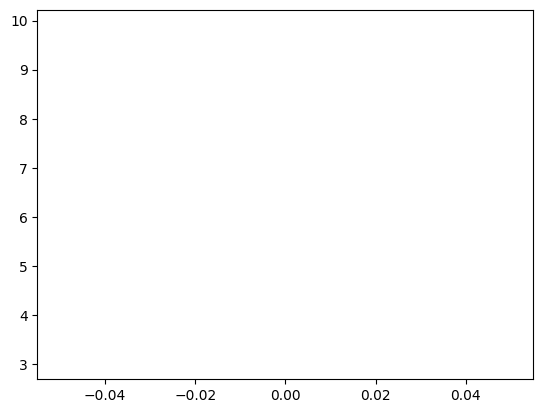

In [252]:
Psi_product_kicked = apply_random_unitaries(Psi_product, epsilon=0.1, sites=[0, 1, 2], symmetric=True)

result = find_nash_eq(Psi_product_kicked, H, max_iter=10000, alpha=10, convergence_threshold=1e-6, symmetric=False, trace_history=True)

print(f"Number of iterations: {result['num_iters']}")
print(f"Exploitability: {result['exploitability']}")
print(f"Converged: {result['converged']}")
print(f"Energy: {result['energy']}")
expl = batch_compute_exploitability(result['state'], H, num_samples=1000)
print(f"Exploitability: {expl}")
plt.plot(result['energy_history'])

In [170]:
comp_basis_state = to_comp_basis(result['state'])
print(comp_basis_state)
print(compute_energy(result['state'], H))
print(result['energy'])

tensor([ 1.0001e+00, -1.5699e-05,  8.9633e-03, -1.4070e-07, -1.5699e-05,
         2.4644e-10, -1.4070e-07,  2.2087e-12], device='mps:0')
tensor([5.9998, 6.0003, 5.9998], device='mps:0')
[5.999758720397949, 6.000320911407471, 5.999758720397949]


Number of iterations: 9
Exploitability: 0
Converged: True
Energy: [-0.03131309896707535, 5.506495475769043, 5.506495475769043]
Exploitability: tensor([0.0370, 3.8355, 3.8355], device='mps:0')


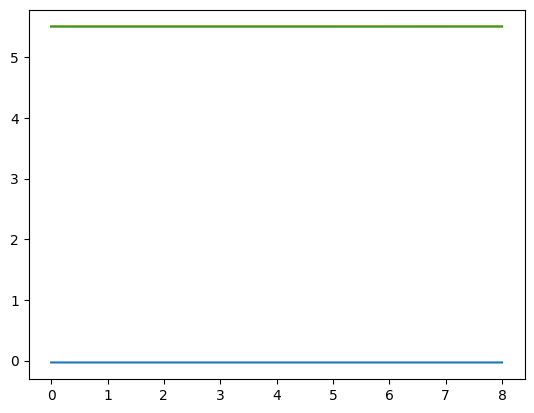

In [157]:
# Psi = deepcopy(Psi_)
result = find_nash_eq(Psi_product_kicked, H, max_iter=10000, alpha=1, convergence_threshold=1e-6, symmetric=False, trace_history=True)

print(f"Number of iterations: {result['num_iters']}")
print(f"Exploitability: {result['exploitability']}")
print(f"Converged: {result['converged']}")
print(f"Energy: {result['energy']}")
expl = batch_compute_exploitability(result['state'], H, num_samples=1000)
print(f"Exploitability: {expl}")
plt.plot(result['energy_history'])

### Explicit gradient version

#### The function

In [253]:
def compute_energy(psi, H):
    return einops.einsum(
        psi, H, psi.conj(),
        'a0 a1 a2, player a0 a1 a2 b0 b1 b2, b0 b1 b2 -> player'
    )

def apply_unitary(U, Psi_component):
    return einops.einsum(
        U, Psi_component,
        'new_phys phys, phys chi_l chi_r -> new_phys chi_l chi_r'
    )

import sys

def find_nash_eq1(Psi, H, max_iter=10000, alpha=0.01, convergence_threshold=1e-6, trace_history=False):
    """
    Find Nash equilibrium using local gradients
    """
    L = len(Psi)
    _iter = 0
    converged = False
    
    # Convert everything to complex64 at the start for dtype consistency
    Psi = [psi.to(t.complex64) for psi in Psi]
    H = [h.to(t.complex64) for h in H]

    X = t.tensor([[0,1],[1,0]], dtype=t.complex64, device=device)
    Y = t.tensor([[0,-1j],[1j,0]], dtype=t.complex64, device=device)
    Z = t.tensor([[1,0],[0,-1]], dtype=t.complex64, device=device)

    E_history = []
    local_max_epl = 0
    while _iter <= max_iter:

        if _iter % 100 == 0:
            print(f"Iteration {_iter}, local max epl: {local_max_epl}")
            sys.stdout.flush()

        unitaries = []
        psi = to_comp_basis(Psi).reshape(2, 2, 2)

        # compute the energies 
        E = compute_energy(psi, t.stack(H))
        E_history.append(E)

        dE_norms = []
        for i in range(L):
            j = (i - 1) % L
            k = (i + 1) % L
            
            # Get 2x2 gradient matrix at site i
            dE_matrix = t.tensordot(H[i], psi, dims=([4, 5, 3], [1, 2, 0]))
            dE_matrix = t.tensordot(psi.conj(), dE_matrix, dims=([j, k], [j, k]))
            
            # Decompose into Pauli basis (gradient lives in su(2))
            # The gradient matrix is Hermitian, extract anti-Hermitian part via Pauli decomposition
            dE_X = -2 * t.trace(dE_matrix @ X).imag  # Coefficient for X
            dE_Y = -2 * t.trace(dE_matrix @ Y).imag  # Coefficient for Y  
            dE_Z = -2 * t.trace(dE_matrix @ Z).imag  # Coefficient for Z
            
            dE = t.stack([dE_X, dE_Y, dE_Z])
            
            # Compute norm (dE is now real)
            dE_norm = t.sqrt(t.sum(dE**2))
            
            # Compute rotation angle
            coef = t.clamp(dE_norm, max=alpha)
            
            # Build unitary: U = exp(i*coef*n·σ) where n = dE/||dE||
            if dE_norm > 1e-10:
                n = dE / dE_norm  # Normalized direction
                unitaries.append(
                    t.eye(2, dtype=t.complex64, device=device) * t.cos(coef) +
                    1j * (n[0] * X + n[1] * Y + n[2] * Z) * t.sin(coef)
                )
            else:
                # No update if gradient is zero
                unitaries.append(t.eye(2, dtype=t.complex64, device=device))
            
            dE_norms.append(dE_norm)
        
        # Apply unitaries
        for i in range(L):
            Psi[i] = apply_unitary(unitaries[i], Psi[i])
        
        Psi = to_canonical_form(Psi, form='A')
        
        _iter = _iter + 1
        local_max_epl = sum(dE_norms).detach().cpu().numpy()

        if sum(dE_norms) < convergence_threshold:
            converged = True
            break

        
    
    if _iter > max_iter:
        print("Max iterations reached")

    result = {
        'converged': _iter < max_iter,
        'energy': E,
        'state': Psi,
        'num_iters': _iter,
        'local_max_epl': local_max_epl,
        'E_history': E_history,
    }

    return result

#### Test: product states

In [267]:
Psi_product_kicked = apply_random_unitaries(get_product_state(L=3, state_per_site=[0, 1, 1], default_dtype=default_dtype, device=device), epsilon=0.1, sites=[0, 1, 2], symmetric=False)
# Psi_product_kicked = get_product_state(L=3, state_per_site=[1, 1, 1], default_dtype=default_dtype, device=device)
H = get_default_H(option='H', default_dtype=default_dtype, device=device)
result = find_nash_eq1(Psi_product_kicked, H, max_iter=1800, alpha=0.001, convergence_threshold=1e-6, trace_history=True)

Iteration 0, local max epl: 0
Iteration 100, local max epl: 0.7870056629180908
Iteration 200, local max epl: 1.1319154500961304
Iteration 300, local max epl: 1.4377251863479614
Iteration 400, local max epl: 1.6864213943481445
Iteration 500, local max epl: 1.8680895566940308
Iteration 600, local max epl: 1.9754830598831177
Iteration 700, local max epl: 2.004324436187744
Iteration 800, local max epl: 1.953461766242981
Iteration 900, local max epl: 1.8249242305755615
Iteration 1000, local max epl: 1.6238391399383545
Iteration 1100, local max epl: 1.3582215309143066
Iteration 1200, local max epl: 1.0386605262756348
Iteration 1300, local max epl: 0.6778961420059204
Iteration 1400, local max epl: 0.29030540585517883
Iteration 1500, local max epl: 0.005703449714928865
Iteration 1600, local max epl: 0.005703449714928865
Iteration 1700, local max epl: 0.005703449714928865
Iteration 1800, local max epl: 0.005703449714928865
Max iterations reached


In [268]:
compute_energy(to_comp_basis(Psi_product_kicked).reshape(2, 2, 2), t.stack(H))

tensor([0.0799, 5.9701, 5.9701], device='mps:0')

Equilibrium found in 1801 iterations, with energy tensor([2.0000+0.j, 2.0000+0.j, 2.0000+0.j], device='mps:0')


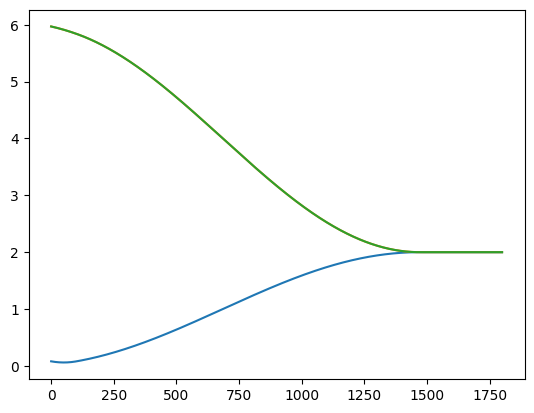

In [269]:
plt.plot(t.stack(result['E_history']).cpu().numpy())
print(f"Equilibrium found in {result['num_iters']} iterations, with energy {result['energy']}")

In [10]:
psi = to_comp_basis(Psi_product_kicked).to(t.complex64).cpu()
H = [h.reshape(8, 8).to(t.complex64).cpu() for h in H]
Y = t.kron(t.eye(2), t.kron(t.tensor([[0, -1j], [1j, 0]]), t.eye(2)))
Z = t.kron(t.eye(2), t.kron(t.tensor([[1, 0], [0, -1]]), t.eye(2))).to(t.complex64).cpu()
X = t.kron(t.eye(2), t.kron(t.tensor([[0, 1], [1, 0]]), t.eye(2))).to(t.complex64).cpu()
print(psi.T.conj() @ (H[1] @ Y - Y @ H[1]) @ psi)
print(psi.T.conj() @ (H[1] @ Z - Z @ H[1]) @ psi)
print(psi.T.conj() @ (H[1] @ X - X @ H[1]) @ psi)


tensor(0.+0.5960j)
tensor(0.+0.j)
tensor(-3.0268e-08+0.j)


/var/folders/1s/zs9ynm1d30v6x5mppn67y8h00000gp/T/ipykernel_6016/3123662175.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4419.)
  print(psi.T.conj() @ (H[1] @ Y - Y @ H[1]) @ psi)


#### Test: GHZ state

In [86]:
Psi_ghz_kicked = apply_random_unitaries(get_ghz_state(L=3, default_dtype=default_dtype, device=device), epsilon=0.8, sites=[0, 1, 2], symmetric=False)
# Psi_product_kicked = get_product_state(L=3, state_per_site=[1, 1, 1], default_dtype=default_dtype, device=device)
H = get_default_H(option='H', default_dtype=default_dtype, device=device)
result = find_nash_eq1(Psi_ghz_kicked, H, max_iter=400, alpha=0.006, convergence_threshold=1e-6, trace_history=True)

Iteration 0, local max epl: 0
Iteration 100, local max epl: 0.4727899432182312
Iteration 200, local max epl: 2.953149760287488e-06
Iteration 300, local max epl: 2.7327987481839955e-06
Iteration 400, local max epl: 3.020582880708389e-06
Max iterations reached


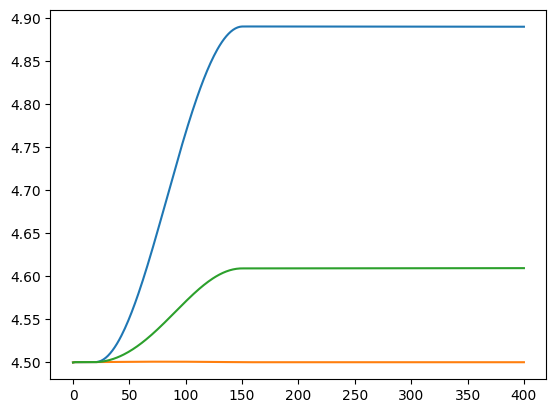

In [18]:
plt.plot(t.stack(result['E_history']).cpu().numpy())

In [19]:
print(f"Equilibrium found in {result['num_iters']} iterations, with energy {result['energy']}")

Equilibrium found in 401 iterations, with energy tensor([4.8904+0.j, 4.4999+0.j, 4.6094+0.j], device='mps:0')


#### Test: randomized state

In [136]:
# Psi = get_rand_mps(L=3, chi=5, d_phys=2, seed=None, default_dtype=default_dtype, device=device, form='A')
# Psi_product_kicked = get_product_state(L=3, state_per_site=[1, 1, 1], default_dtype=default_dtype, device=device)

Psi = get_rand_mps(L=3, chi=2, d_phys=2, seed=None, default_dtype=default_dtype, device=device, form='A')
H = get_default_H(option='H', default_dtype=default_dtype, device=device)
result = find_nash_eq1(Psi, H, max_iter=400, alpha=0.006, convergence_threshold=1e-6, trace_history=True)
expl = batch_compute_exploitability(result['state'], H, num_samples=1000)
print(expl)

Iteration 0, local max epl: 0
Iteration 100, local max epl: 4.574655532836914
Iteration 200, local max epl: 1.4024441242218018
Iteration 300, local max epl: 0.03396667167544365
Iteration 400, local max epl: 0.033966727554798126
Max iterations reached
tensor([0.5315, 0.8220, 1.4373], device='mps:0')


In [149]:
# print(to_comp_basis(result['state']))
state = result['state']
state_ = deepcopy(state)
state = to_canonical_form(state, form='A')
print(test_canonical_form(state_, 'A'))
print(test_canonical_form(state, 'A'))
print(state)
print(state_)

print(to_comp_basis(result['state']))

True
True
[tensor([[[-0.0034+0.j,  1.0000+0.j]],

        [[ 1.0000+0.j,  0.0034+0.j]]], device='mps:0'), tensor([[[-3.3901e-01+0.j,  9.4075e-01+0.j],
         [ 6.2135e-03+0.j, -4.5327e-03+0.j]],

        [[ 9.4076e-01+0.j,  3.3904e-01+0.j],
         [-8.5235e-04+0.j,  3.6864e-03+0.j]]], device='mps:0'), tensor([[[-0.0927+0.j],
         [ 0.2467+0.j]],

        [[ 0.9061+0.j],
         [ 0.3310+0.j]]], device='mps:0')]
[tensor([[[-0.0034+0.j,  1.0000+0.j]],

        [[ 1.0000+0.j,  0.0034+0.j]]], device='mps:0'), tensor([[[-3.3901e-01+0.j,  9.4075e-01+0.j],
         [ 6.2135e-03+0.j, -4.5327e-03+0.j]],

        [[ 9.4076e-01+0.j,  3.3904e-01+0.j],
         [-8.5235e-04+0.j,  3.6864e-03+0.j]]], device='mps:0'), tensor([[[-0.0927+0.j],
         [ 0.2467+0.j]],

        [[ 0.9061+0.j],
         [ 0.3310+0.j]]], device='mps:0')]
tensor([-0.0026+0.j,  0.0041+0.j,  0.0010+0.j, -0.0028+0.j,  0.2636+0.j,  0.0043+0.j,
        -0.0036+0.j,  0.9646+0.j], device='mps:0')


In [145]:

for i in range(10):
    print(batch_compute_exploitability(result['state'], H, num_samples=1000))

tensor([0.0070, 0.4206,    nan], device='mps:0')
tensor([0.0070, 0.4206,    nan], device='mps:0')
tensor([0.0070, 0.4206,    nan], device='mps:0')
tensor([0.0070, 0.4206,    nan], device='mps:0')
tensor([0.0070, 0.4206,    nan], device='mps:0')
tensor([0.0070, 0.4206,    nan], device='mps:0')
tensor([0.0070, 0.4206,    nan], device='mps:0')
tensor([0.0070, 0.4206,    nan], device='mps:0')
tensor([0.0070, 0.4206,    nan], device='mps:0')
tensor([0.0070, 0.4206,    nan], device='mps:0')


Equilibrium found in 401 iterations, with energy tensor([2.5559+0.j, 2.0696+0.j, 2.0697+0.j], device='mps:0')
tensor([0.0070, 0.4206,    nan], device='mps:0')


/Users/linc/Documents/workspace/nash/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/linc/Documents/workspace/nash/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


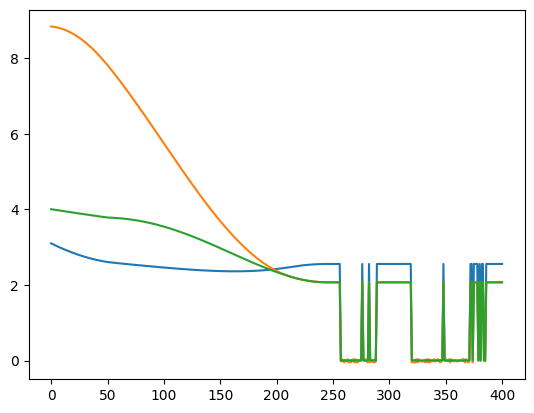

In [150]:
plt.plot(t.stack(result['E_history']).cpu().numpy())
print(f"Equilibrium found in {result['num_iters']} iterations, with energy {result['energy']}")
expl = batch_compute_exploitability(result['state'], H, num_samples=1000)
print(expl)

#### Test: old method with these MPS states

In previous runs it seems that older algorithm with crazy $\alpha$ show convergence to genuine Nash equilibria (Exploitability exactly at zero)

In [241]:
from opt_mps_fiducial_state import find_nash_eq as find_nash_eq_old

Psi = get_rand_mps(L=3, chi=8, d_phys=2, seed=None, default_dtype=default_dtype, device=device, form='A')

Psi_ = deepcopy(Psi)

H = get_default_H(option='H', default_dtype=default_dtype, device=device)
result = find_nash_eq_old(Psi, H, alpha=2000)
expl = batch_compute_exploitability(result['state'], H, num_samples=1000)
print(expl)
print(to_comp_basis(result['state']))
print(test_canonical_form(result['state'], 'A'))
print(result['energy'])

Psi = deepcopy(Psi_)


tensor([ 9.5367e-07,  0.0000e+00, -4.7684e-07], device='mps:0')
tensor([ 0.2692,  0.1765,  0.1487, -0.4398,  0.1924,  0.5514, -0.4867,  0.3208],
       device='mps:0')
True
[4.41633415222168, 3.6478328704833984, 4.114269733428955]


In [242]:
result['state']

[tensor([[[-0.0992, -0.9951]],
 
         [[-0.9951,  0.0992]]], device='mps:0'),
 tensor([[[ 0.5843,  0.6179],
          [ 0.0463,  0.4591]],
 
         [[ 0.5082, -0.6307],
          [-0.6310,  0.0978]]], device='mps:0'),
 tensor([[[ 0.2235],
          [-0.5644]],
 
         [[-0.7727],
          [-0.1856]]], device='mps:0')]

In [243]:
test_canonical_form(result['state'], 'A')

True

In [244]:
state_ = deepcopy(result['state'])
state = to_canonical_form(result['state'], form='A')
print(test_canonical_form(state_, 'A'))
print(test_canonical_form(state, 'A'))
print(state)
print(state_)



True
True
[tensor([[[-0.0992, -0.9951]],

        [[-0.9951,  0.0992]]], device='mps:0'), tensor([[[-0.5843, -0.6179],
         [-0.0463, -0.4591]],

        [[-0.5082,  0.6307],
         [ 0.6310, -0.0978]]], device='mps:0'), tensor([[[-0.2235],
         [ 0.5644]],

        [[ 0.7727],
         [ 0.1856]]], device='mps:0')]
[tensor([[[-0.0992, -0.9951]],

        [[-0.9951,  0.0992]]], device='mps:0'), tensor([[[ 0.5843,  0.6179],
         [ 0.0463,  0.4591]],

        [[ 0.5082, -0.6307],
         [-0.6310,  0.0978]]], device='mps:0'), tensor([[[ 0.2235],
         [-0.5644]],

        [[-0.7727],
         [-0.1856]]], device='mps:0')]


# Tests v1

See `prisoner.ipynb`, that algorithm failed for 3-player product state as well... Therefore, it might be the problem of local, myopic updates in general don't represent the capabilities of players who can apply far-from-identity unitaries.

One resolution is that we can try to compute the best response from random samples

## 2 players

In [276]:
from solver import procrustes_solver, grad_solver

# start with GHZ states
Psi = get_ghz_state(L=2)
result = procrustes_solver(Psi, H, max_iter=1000, alpha=0.01, grad_norm_threshold=1e-6, return_history=True)

RuntimeError: trace: expected a matrix, but got tensor with dim 4